In [1]:
%run pymexDataStartup.py

# things we need for this notebook
from PYMEcs.IO.picasso import read_picasso_hdf, pymedf2csv, picasso_structure_mask_roi
from PYME.IO.image import ImageStack
from PYME.LMVis import pipeline
import pandas as pd

In [2]:
inputdir = '../data/external/picasso/picasso-simulation/'
pymedf, mdh, struc = read_picasso_hdf(os.path.join(inputdir,'origami-simul3_locs.hdf5'))
pymedf2csv(pymedf,inbdir('origami-simul3_locs.csv'))

In [3]:
# currently we do this from the converted hdf but should be possible using csv!
pl = pipeline.Pipeline(inbdir('origami-simul3_locs.hdf'))

In [4]:
# here we check that we have generated the yaml file ina  string as we wanted it
import yaml
dct = yaml.safe_load("""
- tablefilters.FilterTable:
    filters:
      A: [5, 20000]
      error_x: [0, 30]
      error_y: [0, 30]
      sig: [95, 200]
    inputName: Localizations
    outputName: filtered_localizations
- localisations.DensityMapping:
    inputLocalizations: filtered_localizations
    jitterVariable: error_x
    outputImage: renderim
    renderingModule: Gaussian
""")
dct

[{'tablefilters.FilterTable': {'filters': {'A': [5, 20000],
    'error_x': [0, 30],
    'error_y': [0, 30],
    'sig': [95, 200]},
   'inputName': 'Localizations',
   'outputName': 'filtered_localizations'}},
 {'localisations.DensityMapping': {'inputLocalizations': 'filtered_localizations',
   'jitterVariable': 'error_x',
   'outputImage': 'renderim',
   'renderingModule': 'Gaussian'}}]

In [5]:
useVersion1 = False
if useVersion1:
    # version 1: explicitly make the rendering module and insert into existing recipe
    pl.recipe.update_from_yaml("""
- tablefilters.FilterTable:
    filters:
      A: [5, 20000]
      error_x: [0, 30]
      error_y: [0, 30]
      sig: [95, 200]
    inputName: Localizations
    outputName: filtered_localizations
    """)

    from PYME.recipes import localisations
    dm = localisations.DensityMapping(
            inputLocalizations='filtered_localizations',
            jitterVariable="error_x",
            outputImage="renderim",
            pixelSize=5.0,
            renderingModule='Gaussian')
    pl.recipe.add_module(dm)
    pl.recipe.execute()
else:
    # version 2: all in one go from one yaml string
    pl.recipe.update_from_yaml("""
- tablefilters.FilterTable:
    filters:
      A: [5, 20000]
      error_x: [0, 30]
      error_y: [0, 30]
      sig: [95, 200]
    inputName: Localizations
    outputName: filtered_localizations
- localisations.DensityMapping:
    inputLocalizations: filtered_localizations
    jitterVariable: error_x
    outputImage: renderim
    renderingModule: Gaussian
    """)

Created colour filter with chans: []


In [6]:
image = pl.dataSources['renderim']
image.Save(inbdir('origami-simul3.tif'))

/Users/csoe002/Documents/src/PYME-src/python-microscopy/PYME/IO/DataSources/ArrayDataSource.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  r = self.data.__getitem__(keys)


In [7]:
mask, sitesdf = picasso_structure_mask_roi(image,struc,roisize=20)
sitesdf.to_csv(inbdir('origami-simul3_nsites.csv'))
mask.Save(filename=inbdir('origami-simul3-structurelabelmaskroi.tif'))

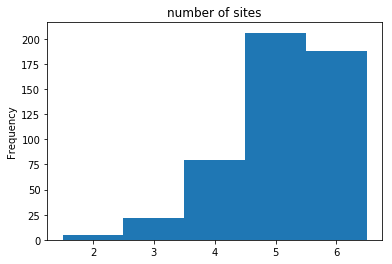

In [8]:
plt.figure()
sitesdf['NSites'].plot(kind='hist', title='number of sites',bins=np.arange(1,7)+0.5)

In [9]:
print(pl.recipe.toYAML())

- tablefilters.FilterTable:
    filters:
      A:
      - 5
      - 20000
      error_x:
      - 0
      - 30
      error_y:
      - 0
      - 30
      sig:
      - 95
      - 200
    inputName: Localizations
    outputName: filtered_localizations
- localisations.DensityMapping:
    inputLocalizations: filtered_localizations
    jitterVariable: error_x
    outputImage: renderim
    renderingModule: Gaussian

